In [631]:
import numpy as np
import matplotlib.pyplot as plt
import random
import stackprinter
import seaborn as sns
from itertools import chain
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as fun
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from tqdm import tqdm, trange
from time import sleep
stackprinter.set_excepthook(style='darkbg2')

In [52]:
train_file = pd.read_csv('/Users/tommy84729/python/DL/HW1/train.csv')
test_file = pd.read_csv('/Users/tommy84729/python/DL/HW1/test.csv')

In [151]:
train_file

,filename,width,height,label,xmin,ymin,xmax,ymax
0,11893820-3x2-xlarge.jpg,862,575,bad,12,238,92,318
1,11893820-3x2-xlarge.jpg,862,575,bad,46,42,104,97
2,11893820-3x2-xlarge.jpg,862,575,good,103,24,150,79
3,11893820-3x2-xlarge.jpg,862,575,good,243,2,291,51
4,11893820-3x2-xlarge.jpg,862,575,bad,166,36,228,99
...,...,...,...,...,...,...,...,...
3523,kljlhk.jpg,1548,1032,good,1481,239,1546,353
3524,kljlhk.jpg,1548,1032,good,328,273,361,312
3525,kljlhk.jpg,1548,1032,good,283,245,318,289
3526,kljlhk.jpg,1548,1032,good,226,251,257,289


In [135]:
train_filename = train_file.filename.unique()
test_filename = test_file.filename.unique()

# Preprocessing : according to train/test file to select train area ,and use the mean size of train to resize train/test data, also do standardization by divided 255. Last, tranform the image data to nd.array

In [273]:
inp_path = '/Users/tommy84729/python/DL/HW1/images'

In [372]:
def preprocessing(data,width,height) : 
    a = []
    width = width
    height = height
    for filename, xmin, xmax, ymin, ymax in zip(data['filename'], data['xmin'], data['xmax'], data['ymin'], data['ymax']) : 
        path_=os.path.join(inp_path,filename)
        img = Image.open(path_).convert(mode = 'RGB').crop((xmin,ymin,xmax,ymax))
        a.append(np.transpose(np.array(img.resize((width,height),Image.ANTIALIAS)))/255)
    return a

In [663]:
train = preprocessing(train_file,80, 80)
test = preprocessing(test_file, 80, 80)

In [664]:
train = np.array(train)
test = np.array(test)

In [668]:
kk = np.load()

numpy.ndarray

In [665]:
np.save('train_array', train)
np.save('test_array' , test)

In [669]:
label_train = []
label_test = []
for i in range(len(train_file['label'])) : 
    if train_file['label'][i] == 'bad' : 
        label_train.append(0)
    elif train_file['label'][i] == 'none' : 
        label_train.append(1)
    else :
        label_train.append(2)

for i in range(len(test_file['label'])) : 
    if test_file['label'][i] == 'bad' : 
        label_test.append(0)
    elif test_file['label'][i] == 'none' : 
        label_test.append(1)
    else :
        label_test.append(2)
label_train = np.array(label_train)
label_test = np.array(label_test)

In [670]:
np.save('label_train_array', label_train)
np.save('label_test_array' , label_test)

# CNN_Model by pytorch

## Data preparation

In [405]:
feature_train = torch.from_numpy(train)
feature_test = torch.from_numpy(test)
target_train = torch.from_numpy(label_train).type(torch.LongTensor)
target_test = torch.from_numpy(label_test).type(torch.LongTensor)

In [406]:
len(feature_train)

3528

In [407]:
train = torch.utils.data.TensorDataset(feature_train, target_train)
test = torch.utils.data.TensorDataset(feature_test, target_test)

## Hyper parameter

In [650]:
learning_rate = 0.005
batch_size = 200
epochs = 50

In [613]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True, drop_last = False)

## Build Model

In [546]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([200, 3, 80, 80]), torch.Size([200]))

In [568]:
class CNN(nn.Module) : 
    def __init__(self) : 
        super(CNN, self).__init__() 
        ## cnn input(3,80,80)
        self.cnn_1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1, padding = 0) # out_put shape : 16*76*76
        # out_channels : filter的個數，kernel_size : feature_detector size(5*5), stride : 移動步伐 , padding = 0 : 周圍不補零 
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.LeakyReLU()
        self.maxpool_1 = nn.MaxPool2d(kernel_size = 2) # out_put shape : 16*38*38
        # kernel : matrix size 
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 0) # out_put shape : 30*34*34
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.maxpool_2 = nn.MaxPool2d(kernel_size = 2) # 30*17*17
        self.cnn_3 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1, padding = 0) # out_put shape : 16*14*14
        self.bn3 = nn.BatchNorm2d(num_features=16)
        self.maxpool_3 = nn.MaxPool2d(kernel_size = 2) # 16*7*7
        self.cnn_4 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 0) # out_put shape : 8*5*5
        self.bn4 = nn.BatchNorm2d(num_features=8)
        self.maxpool_4 = nn.MaxPool2d(kernel_size = 2) # 8*2*2
        self.fc1 = nn.Linear(8 * 2 * 2, 64) 
        self.bn5 = nn.BatchNorm1d(num_features=64)
        self.fc2 = nn.Linear(64, 3) 
        self.bn6 = nn.BatchNorm1d(num_features=3)
        
    def forward(self, x) : 
        x = x.float()
        out = self.cnn_1(x) 
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool_1(out)
        out = self.cnn_2(out) 
        out = self.bn2(out)
        out = self.relu(out) 
        out = self.maxpool_2(out) 
        out = self.cnn_3(out)
        out = self.bn3(out) 
        out = self.relu(out)
        out = self.maxpool_3(out) 
        out = self.cnn_4(out) 
        out = self.bn4(out)
        out = self.relu(out)
        out = self.maxpool_4(out)
 
        out = out.view(-1, 8*2*2) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function 
        out = self.bn5(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn6(out)        
        out = self.relu(out)
        
        return fun.log_softmax(out, dim = 1)

In [651]:
model = CNN().cuda()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  
#loss_fun_1 = nn.CrossEntropyLoss()   
#loss_fun_2 = nn.NLLLoss()

def fit_model(model, optimizer, epoch, train_loader, test_loader, weight) : 
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    if weight == 'True' : 
      loss_fun = nn.CrossEntropyLoss(weight = torch.tensor([1,6,0.2]).cuda())
    else : 
      loss_fun = nn.CrossEntropyLoss()

    for i in range(epoch) : 
        correct_train = 0
        total_train = 0
        total_test = 0
        correct_test = 0
        running_loss = 0.0
        testing_loss = 0.0
        predict_epoch = []
        label_train = []
        label_test = []
        predict_epoch_test = []
        print(f'epoch: {i+1}/{epoch}', end = '\n')
        for train ,label in (train_loader) : 
            train = train.cuda()
            label = label.cuda()
            optimizer.zero_grad() # forward 
            output = model(train)

            loss = loss_fun(output,label)
            running_loss += loss.item()
            #a = list(model.parameters())[0].clone()
            loss.backward() # gradient
            optimizer.step() # update parameters
            #b = list(model.parameters())[0].clone()
            #print(torch.equal(a.data, b.data))
            predict = torch.max(output.data,1)[1]
            predict_epoch.extend(predict.cpu().numpy())
            label_train.extend(label.cpu().numpy())
            total_train += label.size(0)
            correct_train += (predict == label).sum().item() ## correct num

        train_acc.append(correct_train/total_train)
        train_loss.append(running_loss)
        for test ,label in (test_loader) : 
            #test, label = data
            test , label = test.cuda(), label.cuda()
            output = model(test)
            #loss_test = loss_fun(output,label)
            #testing_loss += loss_test.item()
            predict = torch.max(output.data, 1)[1]
            predict_epoch_test.extend(predict.cpu().numpy())
            label_test.extend(label.cpu().numpy())
            total_test +=label.size(0)
            correct_test += (predict == label).sum().item()
        test_acc.append(correct_test/total_test)
        
    return train_acc, train_loss, test_acc, confusion_matrix(label_train, predict_epoch), confusion_matrix(label_test, predict_epoch_test)

CNN(
  (cnn_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu_1): ReLU()
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu_2): ReLU()
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu_3): ReLU()
  (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu_4): ReLU()
  (maxpool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_5): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)


In [671]:
train_acc, train_loss, test_acc,  cnf_train, cnf_test = fit_model(model, input_shape, loss_fun, optimizer, epochs, train_loader, test_loader)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5


KeyboardInterrupt: 

In [661]:
cnf_test

array([[ 72,   1,  16],
       [  6,  13,   3],
       [  2,   4, 277]])

In [634]:
train_acc

[0.7786281179138322,
 0.9291383219954649,
 0.9382086167800453,
 0.9447278911564626,
 0.9458616780045351,
 0.9469954648526077,
 0.9503968253968254,
 0.9461451247165533,
 0.9529478458049887,
 0.953514739229025]

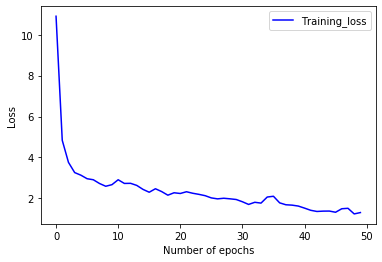

In [658]:
plt.plot(range(epochs), train_loss, 'b-', label='Training_loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('/content/drive/My Drive/DL/DL_HW1/train_loss_q2', dpi = 600)

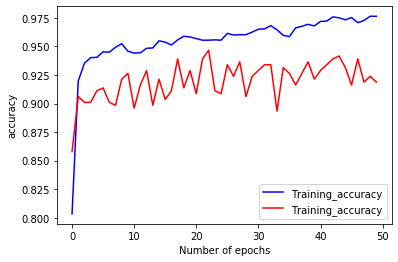

In [655]:
plt.plot(range(epochs), train_acc, 'b-', label='Training_accuracy')
plt.plot(range(epochs), test_acc, 'r-', label='Testing_accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('/content/drive/My Drive/DL/DL_HW1/accuracy_q2', dpi = 600)

In [ ]:
for i in range(3) : 
  print(f'label_{i} accuracy : ',cnf_test[i,i]/np.sum(cnf_test[i,:]))

In [ ]:
model_w = CNN().cuda()
optimizer_w = torch.optim.Adam(model_w.parameters(), lr = learning_rate) 
train_acc, train_loss, test_acc,  cnf_train, cnf_test = fit_model(model_w,  optimizer_w, epochs, train_loader, test_loader, 'True')

In [ ]:
plt.plot(range(epochs), train_loss, 'b-', label='Training_loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Loss of weighted model')
plt.legend()

In [ ]:
plt.plot(range(epochs), train_acc, 'b-', label='Training_accuracy')
plt.plot(range(epochs), test_acc, 'r-', label='Testing_accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
for i in range(3) : 
  print(f'label_{i} accuracy : ',cnf_test[i,i]/np.sum(cnf_test[i,:]))